In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.generate as generate
import readdy_learn.generate.generate_tools.kinetic_monte_carlo as kmc
import readdy_learn.analyze.basis as basis
import readdy_learn.analyze.estimator as rlas
import readdy_learn.analyze.tools as tools
import readdy_learn.analyze.derivative as deriv
import readdy_learn.sample_tools as sample_tools

if False:
    mpl.rcParams['xtick.labelsize'] = 48
    mpl.rcParams['ytick.labelsize'] = 48

    mpl.rcParams['xtick.major.pad'] = 10
    mpl.rcParams['ytick.major.pad'] = 5

    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1

    mpl.rcParams['ytick.major.size'] = 14
    mpl.rcParams['ytick.major.width'] = 2
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1

    mpl.rc('font',**{'size':48, 'family':'serif','serif':['Arial']})
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

    mpl.rc('legend', fontsize=30)


mpl.rcParams['figure.figsize'] = (15, 15)
import matplotlib.pyplot as plt

In [2]:
recompute = False
recompute_traj = False
postfix = "iter_3.5"

In [3]:
plot_concentrations_train_set_fname = 'fusfis2_cv_concentrations_train_{}.eps'.format(postfix)
plot_concentrations_test_set_fname = 'fusfis2_cv_concentrations_test_{}.eps'.format(postfix)
plot_score_curve_fname = 'fusfis2_cv_score_{}.eps'.format(postfix)
plot_expected_estimated_concentrations_fname = 'fusfis2_cv_estimated_concentrations_{}.eps'.format(postfix)

In [4]:
if True:
    timestep = 1e-4
    continuous_counts_target_time = 350
    n_steps=250
    n_species = 4
    tol=5e-6
    interp_degree='regularized_derivative'
    cheat_derivatives = False
    desired_rates = np.array([2e-2, 2e-2, 1e-2, 1e-4, 1e-4, 0,0,0,0,0,0,0,0,0,0, 0,0,0])
    train_initial_state = np.array([[52, 42, 81, 7]])
    # train_initial_state = np.array([[85, 29, 80,  6]])
    # test_initial_states = [[37, 93, 41, 77]]
    test_initial_states = [
        [30,  5, 16, 47], [52, 42, 81,  7], [50, 5, 10,  10], [16, 53,  7, 40], 
        [12, 11,  7, 87], [30,  5, 16, 47], [ 5, 12,  8, 72], [52, 42, 81, 7 ]
    ]
                # 
        #, [55, 32, 79, 24], [48, 39, 29,  5], [ 8, 83, 77, 32]
        #                   [16, 55, 94, 78], , [48,  5, 44, 10], ]
    test_initial_states = [np.array([arr]) for arr in test_initial_states]
    test_traj_idx = 0
    n_gillespie_realizations = 40
    use_gillespie = True
    initial_coefficients_fname = 'fusfis2_initial_coefficients_{}.npy'.format(postfix)
    lasso_coefficients_fname = 'fusfis2_lasso_coefficients_{}.npy'.format(postfix)
    train_traj_counts_fname = 'fusfis2_train_traj_counts_{}.npz'.format(postfix)
    test_traj_counts_fname = 'fusfis2_test_traj_counts_{{}}_{}.npz'.format(postfix)
    cv_results_fname = 'fusfis2_cv_results_{}.npy'.format(postfix)

In [5]:
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(n_species=4, n_boxes=1, diffusivity=[[[0.]], [[0.]], [[0.]], [[0.]]],
                                      init_state=init_state, species_names=["A", "B", "C", "D"])
    sys.add_conversion("A", "D", np.array([desired_rates[0]]))
    sys.add_conversion("D", "A", np.array([desired_rates[1]]))
    sys.add_conversion("D", "B", np.array([desired_rates[2]]))
    sys.add_fusion("A", "B", "C", np.array([desired_rates[3]]))
    sys.add_fission("C", "D", "B", np.array([desired_rates[4]]))

    return sys

In [6]:
def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species=n_species)
    bfc.add_conversion(0, 3)  # A -> D
    bfc.add_conversion(3, 0)  # D -> A
    bfc.add_conversion(3, 1)  # D -> B
    bfc.add_fusion(0, 1, 2)  # A + B -> C
    bfc.add_fission(2, 3, 1) # C -> D + B
    
    # respective backwards reactions
    bfc.add_conversion(1, 3) # B -> D, nope
    bfc.add_fission(2, 0, 1) # C -> A + B, nope
    bfc.add_fusion(3, 1, 2)  # D + B -> C, nope
    
    # some more stuff
    bfc.add_conversion(0, 1) # A -> B, nope
    bfc.add_conversion(1, 0) # B -> A, nope
    
    bfc.add_conversion(0, 2) # A -> C, nope
    bfc.add_conversion(2, 0) # C -> A, nope
    
    bfc.add_conversion(1, 2) # B -> C, nope
    bfc.add_conversion(2, 1) # C -> B, nope
    
    bfc.add_fusion(0, 2, 3) # A + C -> D, nope
    bfc.add_fission(3, 0, 2) # D -> A + C, nope
    
    bfc.add_fusion(0, 3, 2) # A + D -> C, nope
    bfc.add_fission(2, 0, 3) # C -> A + D, nope
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc

In [10]:
ld_derivative_config = {
    'ld_derivative_atol': 1e-4, 
    'ld_derivative_rtol': None, 
    'ld_derivative_linalg_solver_maxit': 100000, 
    'ld_derivative_alpha': 1e-1,
    'ld_derivative_solver': 'lgmres',
    'ld_derivative_linalg_solver_tol': 1e-6,
    'ld_derivative_use_preconditioner': False
}
def get_train_traj(updateAndPersist=True):
    if recompute_traj or not os.path.exists(train_traj_counts_fname):
        if os.path.exists(train_traj_counts_fname):
            os.remove(train_traj_counts_fname)
        if use_gillespie:
            #_, counts = generate.generate_kmc_events(lambda: set_up_system(train_initial_state), n_steps)
            _, counts = generate.generate_averaged_kmc_counts(lambda: set_up_system(train_initial_state), 
                                                                  n_steps, timestep,
                                                                  n_realizations=n_gillespie_realizations)
        else:
            _, counts = generate.generate_continuous_counts(desired_rates, train_initial_state, get_bfc(), 
                                                                continuous_counts_target_time/timestep)
    else:
        counts = train_traj_counts_fname
    train_traj = tools.Trajectory(counts, timestep, interpolation_degree=interp_degree, 
                                  verbose=False, fname=train_traj_counts_fname, **ld_derivative_config)
    if cheat_derivatives:
        system = set_up_system(train_initial_state)
        train_traj.interpolation_degree = None
        suite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc(), interp_degree=interp_degree, tol=tol, 
                                               init_xi=np.ones_like(desired_rates)*.0)
        estimator = suite.get_estimator(verbose=True, interp_degree=interp_degree)
        data, expected = estimator._get_slice(None)
        theta = estimator.get_theta(data)
        theta = np.transpose(theta, axes=(0, 2, 1))
        dx = theta.dot(desired_rates)
        train_traj.dcounts_dt = dx
        
        train_traj.interpolation_degree = interp_degree
    
    if updateAndPersist:
        train_traj.update()
        train_traj.persist()
    return train_traj

def get_test_traj_fname(n=0):
    return test_traj_counts_fname.format(n)

def get_test_traj(n=0):
    init = test_initial_states[n]
    if recompute_traj or not os.path.exists(get_test_traj_fname(n)):
        if os.path.exists(get_test_traj_fname(n)):
            os.remove(get_test_traj_fname(n))
        if use_gillespie:
            _, counts = generate.generate_averaged_kmc_counts(lambda: set_up_system(init), n_steps, timestep,
                                                              n_realizations=n_gillespie_realizations, njobs=1) 
            #_, counts = generate.generate_kmc_events(lambda: set_up_system(init), n_steps)
        else:
            _, counts = generate.generate_continuous_counts(desired_rates, test_initial_state, get_bfc(), 
                                                            timestep, continuous_counts_target_time/timestep)
    else:
        counts = get_test_traj_fname(n)
    test_traj = tools.Trajectory(counts, timestep, interpolation_degree=interp_degree, verbose=False, 
                                 fname=get_test_traj_fname(n), **ld_derivative_config)
    if cheat_derivatives:
        system = set_up_system(init)
        test_traj.interpolation_degree = None
        suite = sample_tools.Suite.from_trajectory(test_traj, system, get_bfc(), interp_degree=interp_degree, tol=tol, 
                                               init_xi=np.ones_like(desired_rates)*.0)
        estimator = suite.get_estimator(verbose=True, interp_degree=interp_degree)
        data, expected = estimator._get_slice(None)
        theta = estimator.get_theta(data)
        theta = np.transpose(theta, axes=(0, 2, 1))
        dx = theta.dot(desired_rates)
        test_traj.dcounts_dt = dx
        
        test_traj.interpolation_degree = interp_degree
    test_traj.update()
    test_traj.persist()
    return test_traj

In [8]:
def plot_results(traj, rates, title=None, outfile=None):
    from scipy.integrate import odeint
    bfc = get_bfc()
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(rates, theta)
    def fun_reference(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(desired_rates, theta)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    # f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
    xs = traj.times
    num_solution = odeint(fun, traj.counts[0], xs)
    reference_soln = odeint(fun_reference, traj.counts[0], xs)
    axes = [ax1, ax2, ax3, ax4]
    labels=["A", "B", "C", "D"]
    if title is not None:
        f.suptitle(title)
    for i in range(traj.n_species):
        axes[i].plot(xs, traj.counts[:,i], label='gillespie realization')
        axes[i].plot(xs, num_solution[:, i], label='estimated rates')
        axes[i].plot(xs, reference_soln[:, i], 'k--', label='original rates')
        axes[i].set_title("Concentration of %s particles over time" % labels[i])
        axes[i].legend()
        
    if outfile is not None:
        f.savefig(outfile)
    plt.show()

## Estimate good regularization parameter for derivatives

In [18]:
train_traj = get_train_traj(updateAndPersist=False)
train_traj.interpolation_degree = 'pw_linear'
train_traj.update()

Box(children=(Text(value=''), IntProgress(value=0)))

In [86]:
def estimate_noise_variance(xs, ys):
    import scipy.optimize as so
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import ElasticNetCV as interp
    
    poly_feat = PolynomialFeatures(degree=15)
    regression = interp(n_alphas=100)
    pipeline = Pipeline([("poly", poly_feat), ("regression", regression)])
    pipeline.fit(xs[:, np.newaxis], ys)

    ff = lambda t: pipeline.predict(t[:, np.newaxis])
    return np.var(ff(xs) - ys, ddof=0), ff

In [87]:
iix = []
for species in range(train_traj.n_species):
    counts = train_traj.counts[:, species]
    indices = 1 + np.where(counts[:-1] != counts[1:])[0]
    indices = np.insert(indices, 0, 0)
    if indices[-1] != len(counts) -1:
        indices = np.append(indices, len(counts) - 1)
    iix.append(indices)

In [ ]:
for species in range(train_traj.n_species):
    counts = train_traj.counts[:, species]
    var, ff = estimate_noise_variance(train_traj.times, counts)
    plt.plot(train_traj.times[iix[species]], ff(train_traj.times[iix[species]]))
    plt.plot(train_traj.times[iix[species]], counts[iix[species]], 'k--')

## Calculate derivatives

In [15]:
train_traj = get_train_traj()

Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 7197 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

WARNING - increasing large gradient norm: 762.1233995878571 -> 865.7022896211922


KeyboardInterrupt: 

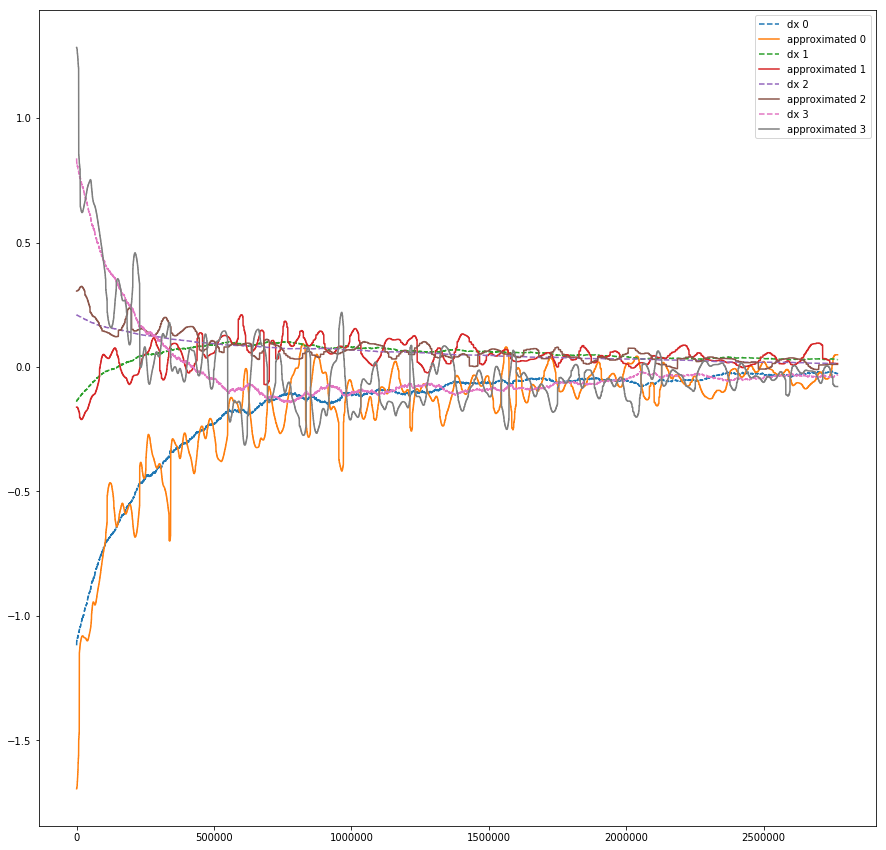

In [20]:
if True:
    system = set_up_system(train_initial_state)
    suite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc(), interp_degree=interp_degree, tol=tol, 
                                               init_xi=np.ones_like(desired_rates)*.0)
    estimator = suite.get_estimator(verbose=True, interp_degree=interp_degree)
    data, expected = estimator._get_slice(None)
    theta = estimator.get_theta(data)
    theta = np.transpose(theta, axes=(0, 2, 1))
    dx = theta.dot(desired_rates)
    plt.figure(figsize=(15, 15))
    for species in range(4):
        xx = dx[:, species]
        plt.plot(xx, '--', label='dx {}'.format(species))
        xx = expected[:, species]
        plt.plot(xx, label='approximated {}'.format(species))
    plt.legend()
    plt.show()

In [21]:
for n in range(len(test_initial_states)):
    print("------- get test traj n={} -------".format(n))
    get_test_traj(n)
test_trajs = [get_test_traj_fname(n) for n in range(len(test_initial_states))]
test_traj = get_test_traj(test_traj_idx)

------- get test traj n=0 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 7235 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 2057 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 405 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 8500 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=1 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6947 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 2078 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 883 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 7451 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=2 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6912 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 1781 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 390 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 7938 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=3 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6294 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 2268 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 912 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 6837 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=4 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6835 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 2224 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 464 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 8129 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=5 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6812 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 1954 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 373 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 8056 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=6 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6713 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 2315 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 505 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 8022 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

------- get test traj n=7 -------


Box(children=(Text(value=''), IntProgress(value=0)))

---- calculating regularized derivative for species 0 with 6628 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 1 with 2077 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 2 with 878 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

---- calculating regularized derivative for species 3 with 7134 data points ----


Box(children=(Label(value='Progress: 0/0 it, atol=?/0.0001, rtol=?/None'),))

In [22]:
# plot concentrations
system = set_up_system(train_initial_state)
suite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc())

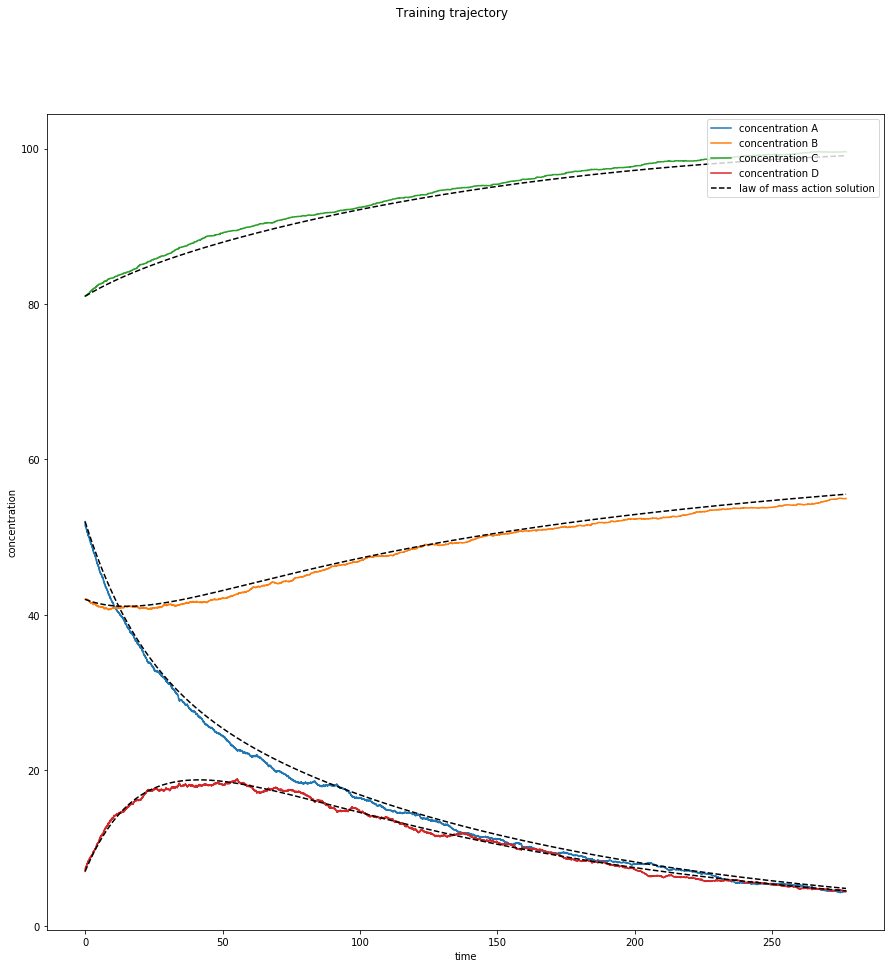

In [23]:
config = system.get_trajectory_config()
estimated = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), train_traj.counts[0], train_traj.times)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Training trajectory')
ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
for t in config.types.keys():
    type_id = config.types[t]
    ax1.plot(train_traj.times, train_traj.counts[:, type_id], label="concentration " + t)
    ax1.plot(train_traj.times, estimated[:, type_id], "k--", 
             label=None if type_id != 3 else "law of mass action solution")
ax1.legend(loc="upper right")
fig.savefig(plot_concentrations_train_set_fname)

In [24]:
if False:
    fig, axes = plt.subplots(nrows=4, ncols=2)

    for ix in range(len(test_initial_states)):
        row = ix // 2
        col = ix % 2

        ttraj = get_test_traj(ix)
        tsys = set_up_system(test_initial_states[ix])
        tsuite = sample_tools.Suite.from_trajectory(ttraj, tsys, get_bfc())
        tconf = tsys.get_trajectory_config()
        testimated = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), ttraj.counts[0], ttraj.times)

        axes[row][col].set_title('test system {}'.format(ix))
        for t in config.types.keys():
            type_id = config.types[t]
            axes[row][col].plot(ttraj.times, ttraj.counts[:, type_id], label="concentration " + t)
            axes[row][col].plot(ttraj.times, testimated[:, type_id], "k--")

In [25]:
if False:
    fig, axes = plt.subplots(nrows=4, ncols=2)

    for ix in range(len(test_initial_states)):
        row = ix // 2
        col = ix % 2

        ttraj = get_test_traj(ix)
        tsys = set_up_system(test_initial_states[ix])
        tsuite = sample_tools.Suite.from_trajectory(ttraj, tsys, get_bfc())
        tconf = test_system.get_trajectory_config()
        testimator = suite.get_estimator(verbose=False, interp_degree=interp_degree)
        data, expected = estimator._get_slice(None)
        theta = estimator.get_theta(data)
        theta = np.transpose(theta, axes=(0, 2, 1))
        dx = theta.dot(desired_rates)

        axes[row][col].set_title('test system {}'.format(ix))
        for t in config.types.keys():
            type_id = config.types[t]
            xx = dx[:, type_id]
            axes[row][col].plot(xx, '--', label='dx {}'.format(species))
            xx = expected[:, type_id]
            axes[row][col].plot(xx, label='approximated {}'.format(species))

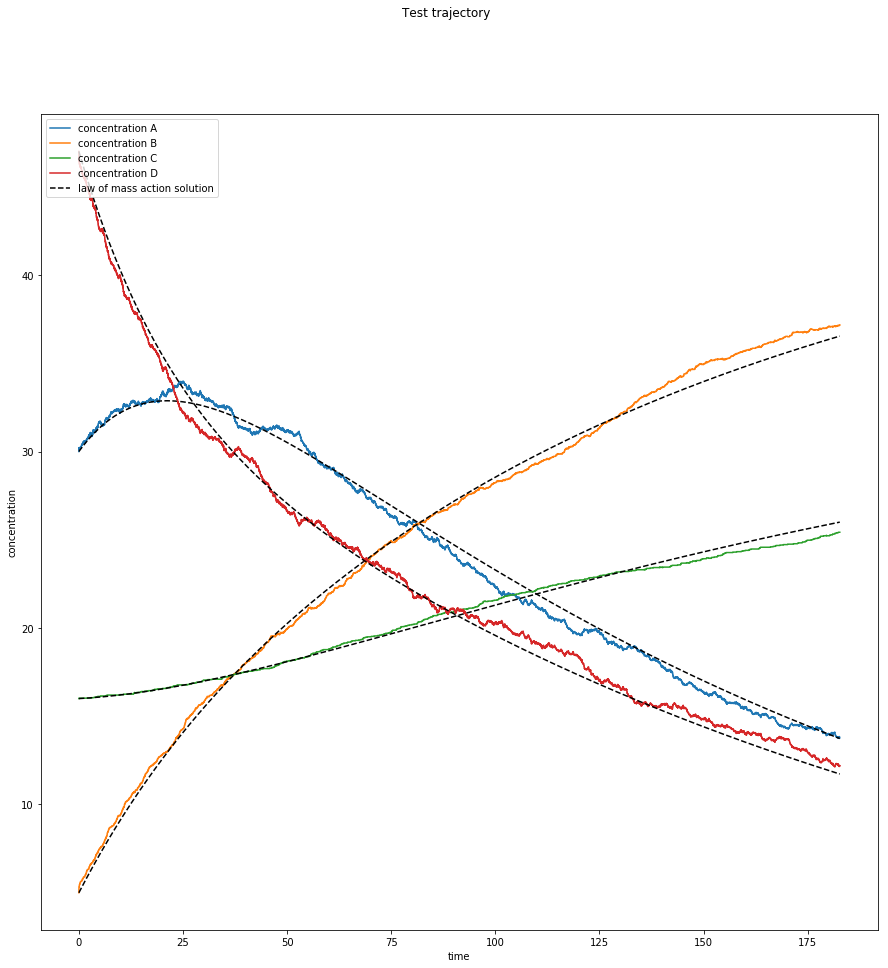

In [26]:
test_system = set_up_system(test_initial_states[test_traj_idx])
test_suite = sample_tools.Suite.from_trajectory(test_traj, test_system, get_bfc())
config = test_system.get_trajectory_config()
estimated = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), test_traj.counts[0], test_traj.times)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Test trajectory')
ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
# ax1.set_autoscaley_on(False)
# ax1.set_ylim([0, 130])
for t in config.types.keys():
    type_id = config.types[t]
    ax1.plot(test_traj.times, test_traj.counts[:, type_id], label="concentration " + t)
    ax1.plot(test_traj.times, estimated[:, type_id], "k--", 
             label=None if type_id != 3 else "law of mass action solution")
ax1.legend(loc="upper left")
fig.savefig(plot_concentrations_test_set_fname)

In [27]:
estimator = suite.get_estimator(interp_degree=interp_degree)

# estimate initial guess

In [28]:
system = set_up_system(train_initial_state)
suite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc(), interp_degree=interp_degree, tol=tol, 
                                           init_xi=np.ones_like(desired_rates)*.0)

In [29]:
estimator = suite.get_estimator(verbose=True, interp_degree=interp_degree)
if recompute or not os.path.exists(initial_coefficients_fname):
    estimator.fit(None)
    if estimator.success_:
        init_rates = estimator.coefficients_
        np.save(initial_coefficients_fname, init_rates)
    else:
        print(":-(")
else:
    init_rates = np.load(initial_coefficients_fname)

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
15 / 30000 iterations


In [30]:
print("initial guess: {}".format(init_rates))

initial guess: [  2.01332675e-02   2.08159520e-02   8.44731327e-03   1.24921393e-04
   1.47438850e-04   0.00000000e+00   0.00000000e+00   5.92336702e-18
   3.02355205e-05   0.00000000e+00   6.01689429e-04   0.00000000e+00
   6.49590972e-03   3.61652224e-03   0.00000000e+00   5.80575987e-04
   4.69509930e-17   0.00000000e+00]


# CV

In [39]:
alphas = np.linspace(0, 15, num=32)
l1_ratios = np.array([1]) #np.linspace(0, 1, num=8) #np.array([0])
# this yielded bleh results with tol=tol (5e-6)
# this worked o.k. with tol=1e-7
# try 1e-10 now
# o.k., try 1e-12
cv = rlas.CV(train_traj, get_bfc(), alphas, l1_ratios, 5, init_rates*0., test_traj=test_trajs, maxiter=3000000, 
             rescale=False, tol=1e-12, n_jobs=4)

In [40]:
if recompute or not os.path.exists(cv_results_fname):
    cv.fit_cross_trajs()
    np.save(cv_results_fname, cv.result)
else:
    cv.result = np.load(cv_results_fname)

In [41]:
def plot_cv_results(cv, mainscore=0, plot_others=False):
    xs = {}
    ys = {}
    allys = {}
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'][mainscore])
                allys[l1_ratio].append(r['scores'])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores'][mainscore]]
                allys[l1_ratio] = [r['scores']]
    f, ax = plt.subplots(figsize=(20, 20))
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys = np.array(ys[l1_ratio])
        l1allys = np.array([np.array(arr) for arr in allys[l1_ratio]]).T
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        
        l1allys = [arr[sorts] for arr in l1allys]
        if l1_ratio == 1:
            ax.plot(l1xs, -l1ys, label='score l1={}'.format(l1_ratio) if plot_others else None)
            
            for ix, ys in enumerate(l1allys):
                if np.argmin(-ys) != 0:
                    print("found one: {} with argmin {}".format(ix, np.argmin(ys)))
                if plot_others:
                    ax.plot(l1xs, -ys, label='test set {}'.format(ix))
    f.suptitle('Cross-validation scores')
    ax.set_ylabel('score')
    ax.set_xlabel('$\\alpha$')
    plt.legend()
    f.savefig(plot_score_curve_fname)
    plt.show()

found one: 0 with argmin 4
found one: 2 with argmin 4
found one: 3 with argmin 0
found one: 5 with argmin 4


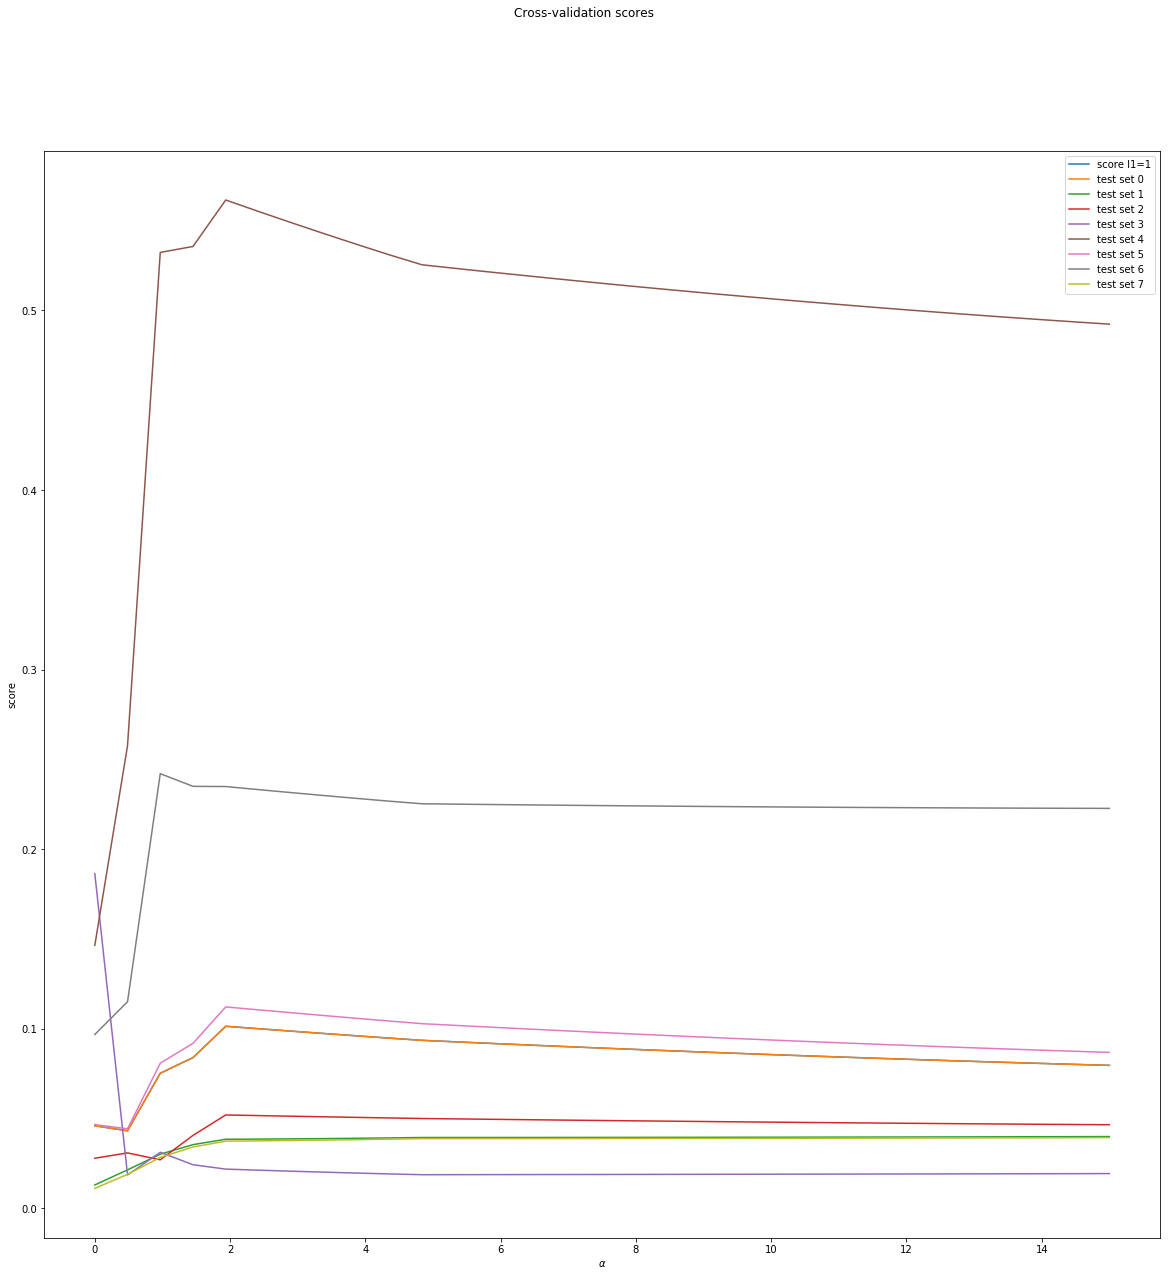

In [42]:
plot_cv_results(cv, test_traj_idx, True)

In [43]:
def best_params(cv, scoreidx=None):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    for r in cv.result:
        if len(r['scores']) > 0:
            if scoreidx is None:
                currscore = np.mean(r['scores'])
            else:
                currscore = r['scores'][scoreidx]
            if current_best_score >= 0:
                if -currscore < current_best_score:
                    current_best_score = -currscore
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -currscore
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio, current_best_score

In [53]:
alpha, l1_ratio, score = best_params(cv, 5)
print("params: alpha={}, l1={} with corresponding score {}".format(alpha, l1_ratio, score))

params: alpha=0.4838709677419355, l1=1 with corresponding score 0.044197468423398216


In [ ]:
if and not recompute and os.path.exists(lasso_coefficients_fname):
    rates = np.load(lasso_coefficients_fname)
else:
    system = set_up_system(train_initial_state)
    optsuite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc(), interp_degree=interp_degree, 
                                                  tol=1e-14, alpha=alpha, l1_ratio=l1_ratio, 
                                                  init_xi=np.ones_like(desired_rates)*.0)
    estimator = optsuite.get_estimator(verbose=True, interp_degree=interp_degree)
    estimator.fit(None)
    if estimator.success_:
        rates = estimator.coefficients_
        np.save(lasso_coefficients_fname, rates)
    else:
        raise ValueError('*_*')

In [ ]:
cutoff = 1e-8

print("initial guess after applying cutoff:")
init_rrates = init_rates[:]
init_rrates[np.where(init_rrates <= cutoff)] = 0
print(init_rrates)

print("estimated rates after applying cutoff:")
rrates = rates[:]
idx = np.where(rates <= cutoff)
rrates[idx] = 0
print(rrates)

In [ ]:
config = system.get_trajectory_config()
expected = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), train_traj.counts[0], train_traj.times)
estimated = sample_tools.Suite.estimated_behavior(rrates, get_bfc(), train_traj.counts[0], train_traj.times)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Estimated model')
ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
for t in config.types.keys():
    type_id = config.types[t]
    # ax1.plot(train_traj.times, expected[:, type_id], "k:", label=None if type_id != 0 else 'underlying model')
    ax1.plot(train_traj.times, train_traj.counts[:, type_id], "-", linewidth=.5, color='grey', 
             label=None if type_id != 0 else 'Gillespie realization')
    ax1.plot(train_traj.times, estimated[:, type_id], "--", label="estimated concentration " + t)
ax1.legend(loc="upper right")
fig.savefig(plot_expected_estimated_concentrations_fname)